In [3]:
import numpy as np
import matplotlib.pyplot as plt

We consider the homogenous equation of spring mass system:
$$
m x'' + \nu x' + kx = 0
$$
with $x(0)=x_0$ and $x'(0) = x_1$.

The solution to this ODE is
$$x(t) = x_0 \exp\left(C t/2\right) \cos\left(t\sqrt{K-C^2/4}\right)$$
where $C=\frac{\nu}{m}$ and $K = \frac{k}{m}$ and $x_1=-C$.

In [4]:
m = 1 # Mass
k = 2 # Stiffness
nu = 1 #0.1 # damping coefficient
t = 1
C = nu/m
K = k/m
t = np.linspace(0,10,100)
x0 = 3
x = x0 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)

Text(0, 0.5, 'Displacement')

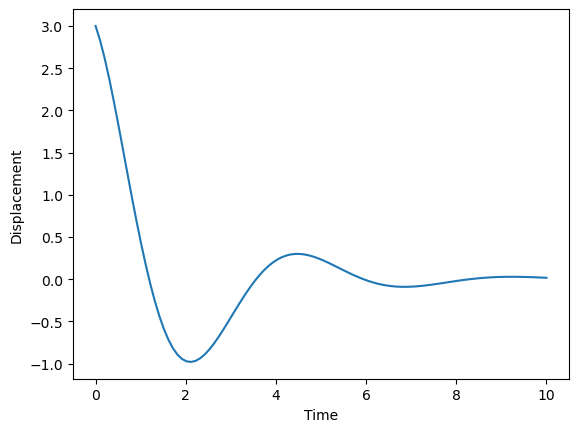

In [5]:
plt.plot(t, x)
plt.xlabel('Time')
plt.ylabel('Displacement')

Carry out a local sensitivity analysis for this system.
1. Describe which variables you treat as inputs and what uncertainties you assume for them. You may choose whichever values you desire for the parameters.
2. Clearly define what your quantity(ies) of interest or output(s) are?
3. What are the most sensitive inputs? Which are the least sensitive?
4. Does it depend on which quantity of interest you choose?
5. What is the expected variance of the quantities of interest?

You may use analytic or numerical approximation to calculate the derivatives of the model.

In [22]:
## Inputs
m = 1 # Mass 1% uncertainty -> sigma_m = 0.01
k = 2 # Stiffness 25% -> sigma_k = 0.25*2 = 0.5
nu = 1 # damping coefficient 15% -> 0.15
x0 = 3 # between 1 and 4 ->  1

t = np.linspace(0,10,100)

# C = nu/m
# K = k/m
# x = x0 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)

t = 5 #


def model(m, k, nu, x0):
    C = nu/m
    K = k/m
    return x0 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)

# Local sensitivity analysis

Choose different time points and look how the sensitivity and variance change

## Advanced
Instead of the displacement at a given time, can you come up with a post processing step to extract the amplitude of the overshoot? How is it's sensitivity different than the sensitivity of the output at $t\approx 2$?

In [30]:
# choose a finite difference step that's sqrt(function's accuracy)
eps = 1e-8 # machine-epsilon typically 1e-16
y0 = model(m, k, nu, x0)
dydm = (model(m*(1+eps), k, nu, x0) - y0)/(eps*m)

dydk = (model(m, k*(1+eps), nu, x0) - y0)/(eps*k)

dydnu = (model(m, k, nu*(1+eps), x0) - y0)/(eps*nu)

dydx0 = (model(m, k, nu, x0*(1+eps)) - y0)/(eps*x0)

In [31]:
dydm, dydk, dydnu, dydx0

(0.8091722347725039,
 -0.151327689268399,
 -0.5065168839912815,
 0.07762409696502695)

In [32]:
var_y = (dydm*0.01)**2 + (dydk*.5)**2 + (dydnu*.15)**2 + (dydx0*1)**2
np.sqrt(var_y)

0.13262194103843528

In [33]:
np.array([(dydm*0.01)**2 , (dydk*.5)**2, (dydnu*.15)**2, (dydx0*1)**2])/var_y

array([0.00372264, 0.3254963 , 0.32820078, 0.34258028])

# Monte Carlo Approach

In [1]:
import chaospy as cp

In [7]:
mass = cp.Uniform(m*0.99, m*1.01)
stiffness = cp.Uniform(k*0.75, k*1.25)
damping = cp.Uniform(nu*0.85, nu*1.15)
x_init = cp.Uniform(1, 4)

*NOTE* this is implemented in `monte_carlo.py` as `generate_samples...`

In [8]:
mass.__str__()

'Uniform(lower=0.99, upper=1.01)'

In [9]:
jpdf = cp.J(mass, stiffness, damping, x_init)

In [10]:
jpdf

J(Uniform(lower=0.99, upper=1.01), Uniform(lower=1.5, upper=2.5), Uniform(lower=0.85, upper=1.15), Uniform(lower=1, upper=4))

In [171]:
np.random.seed(2023)
Ns = 2000
sample_method = 'hammersley' #'R' # 'sobol', 'hammersley'
d = [mass, stiffness, damping, x_init]
number_of_parameters = len(d)
j2pdf = [eval("cp."+d.__str__()) for d in jpdf] + [eval("cp."+d.__str__())for d in jpdf] # Just duplicates the random variables to get independent sampling

# Make a joint distribution object
j2pdf = cp.J(*j2pdf)

Xtot = j2pdf.sample(Ns, sample_method)



A = Xtot[0:number_of_parameters].T
B = Xtot[number_of_parameters:].T

C = np.empty((number_of_parameters, Ns, number_of_parameters))
# create C sample matrices
for i in range(number_of_parameters):
    C[i, :, :] = B.copy()
    C[i, :, i] = A[:, i].copy()


```
Xtot[0] -> mass
Xtot[1] -> stiffness
..
Xtot[4] -> mass 2
```

In [139]:
C[0] # Mass adjusted B matrix

array([[0.995625  , 1.89053254, 0.86868512, 1.0212766 ],
       [1.005625  , 1.96745562, 0.88633218, 1.04255319],
       [0.993125  , 2.0443787 , 0.90397924, 1.06382979],
       [1.003125  , 2.12130178, 0.9216263 , 1.08510638],
       [0.998125  , 2.19822485, 0.93927336, 1.10638298],
       [1.008125  , 2.27514793, 0.95692042, 1.12765957],
       [0.991875  , 2.35207101, 0.97456747, 1.14893617],
       [1.001875  , 2.42899408, 0.99221453, 1.17021277],
       [0.996875  , 1.51183432, 1.00986159, 1.19148936],
       [1.006875  , 1.5887574 , 1.02750865, 1.21276596],
       [0.994375  , 1.66568047, 1.04515571, 1.23404255],
       [1.004375  , 1.74260355, 1.06280277, 1.25531915],
       [0.999375  , 1.81952663, 1.08044983, 1.27659574],
       [1.009375  , 1.8964497 , 1.09809689, 1.29787234],
       [0.9903125 , 1.97337278, 1.11574394, 1.31914894],
       [1.0003125 , 2.05029586, 1.133391  , 1.34042553],
       [0.9953125 , 2.12721893, 0.85207612, 1.36170213],
       [1.0053125 , 2.20414201,

In [172]:
yA = np.empty(A.shape[0])
for idx, row in enumerate(A):
    yA[idx] = model(row[0], row[1], row[2], row[3])
    
yB = np.empty(B.shape[0])
for idx, row in enumerate(B):
    yB[idx] = model(row[0], row[1], row[2], row[3])

yC = np.empty((number_of_parameters, A.shape[0]))
for i in range(number_of_parameters):
    for idx, row in enumerate(C[i]):
        yC[i, idx] = model(row[0], row[1], row[2], row[3])
    

ValueError: setting an array element with a sequence.

In [141]:
y_a = yA
y_b = yB
s = np.zeros(number_of_parameters)
st = np.zeros(number_of_parameters)

mean = 0.5*(np.mean(y_a,axis=0) + np.mean(y_b,axis=0))

y_a_center = y_a - mean
y_b_center = y_b - mean
f0sq = np.mean(y_a_center,axis=0) * np.mean(y_b_center,axis=0) # 0 when data is centered
var_est = np.var(y_b, axis=0)
for i, y_c_i in enumerate(yC):
    y_c_i_center = y_c_i - mean
    s[i] = (np.mean(y_a_center*y_c_i_center, axis=0)-f0sq)/var_est
    st[i] = np.mean(y_b_center*(y_b_center-y_c_i_center), axis=0)/var_est

In [142]:
s

array([-0.02009014,  0.22900308,  0.2049255 ,  0.53183367])

In [143]:
st

array([0.00394083, 0.28358144, 0.2084256 , 0.63181245])

In [91]:
s

array([0.00412637, 0.24236681, 0.16264218, 0.49834011])

In [92]:
st

array([0.00283695, 0.29875915, 0.23335781, 0.57834277])

## Multiple outputs

In [107]:
# Already defined out inputs
d = [mass, stiffness, damping, x_init]
def model(m, k, nu, x0):
    C = nu/m
    K = k/m
    t=1
    y0 = x0 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)
    t=2
    y1 = x0 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)
    t=5
    y2 = x0 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)
    return [y0,y1,y2]

In [173]:
yA = np.empty((A.shape[0], 3))
for idx, row in enumerate(A):
    yA[idx] = model(row[0], row[1], row[2], row[3])
    
yB = np.empty((B.shape[0], 3))
for idx, row in enumerate(B):
    yB[idx] = model(row[0], row[1], row[2], row[3])

yC = np.empty((number_of_parameters, A.shape[0], 3))
for i in range(number_of_parameters):
    for idx, row in enumerate(C[i]):
        yC[i, idx] = model(row[0], row[1], row[2], row[3])
    

In [174]:
y_a = yA
y_b = yB
s = np.zeros((number_of_parameters, 3))
st = np.zeros((number_of_parameters, 3))

mean = 0.5*(np.mean(y_a,axis=0) + np.mean(y_b,axis=0))

y_a_center = y_a - mean
y_b_center = y_b - mean
f0sq = np.mean(y_a_center,axis=0) * np.mean(y_b_center,axis=0) # 0 when data is centered
var_est = np.var(y_b, axis=0)
for i, y_c_i in enumerate(yC):
    y_c_i_center = y_c_i - mean
    s[i] = (np.mean(y_a_center*y_c_i_center, axis=0)-f0sq)/var_est
    st[i] = np.mean(y_b_center*(y_b_center-y_c_i_center), axis=0)/var_est

In [175]:
s[1], st[1]

(array([0.56349888, 0.11026276, 0.2347318 ]),
 array([0.63044532, 0.12152285, 0.29909922]))

In [176]:
s[2], st[2]

(array([-0.00314828,  0.07685619,  0.16260331]),
 array([0.00237642, 0.08163792, 0.21598542]))

In [177]:
s[3], st[3]

(array([0.36991238, 0.79760508, 0.51955469]),
 array([0.43886573, 0.81334072, 0.56796221]))

In [178]:
y_a.shape

(2000, 3)

In [179]:
y_a.mean(axis=0)
y_a.std(axis=0)

array([0.21485263, 0.30615756, 0.08174203])

# Polynomial Chaos

In [122]:

t = 5 #


def model(m, k, nu, x0):
    C = nu/m
    K = k/m
    return x0 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)

In [125]:
joint_distribution = cp.J(mass, stiffness, damping, x_init)

# 2. generate orthogonal polynomials
polynomial_order = 2
poly = cp.generate_expansion(polynomial_order, joint_distribution)
poly

polynomial([1.0, q3-2.5, q2-1.0, q1-2.0, q0-1.0, q3**2-5.0*q3+5.5,
            q2*q3-q3-2.5*q2+2.5, q2**2-2.0*q2+0.9925,
            q1*q3-2.0*q3-2.5*q1+5.0, q1*q2-2.0*q2-q1+2.0,
            q1**2-4.0*q1+3.9166666666666665, q0*q3-q3-2.5*q0+2.5,
            q0*q2-q2-q0+1.0, q0*q1-q1-2.0*q0+2.0,
            q0**2-2.0*q0+0.9999666666666667])

In [144]:
joint_distribution = cp.J(mass, stiffness, damping, x_init)

# 2. generate orthogonal polynomials
polynomial_order = 4
poly = cp.generate_expansion(polynomial_order, joint_distribution)

# 3.1 generate samples
number_of_coefficients =  len(poly) 
number_of_samples =  3*number_of_coefficients
samples = joint_distribution.sample(size=number_of_samples, rule='R')

# 3.2 evaluate the simple model for all samples
model_evaluations = model(samples[0], samples[1], samples[2], samples[3])

# 3.3 use regression to generate the polynomial chaos expansion
gpce_regression = cp.fit_regression(poly, samples, model_evaluations)

In [145]:
cp.sensitivity.Sens_m(gpce_regression, joint_distribution)

array([0.00342576, 0.23331945, 0.16006249, 0.51881203])

In [147]:
cp.Var(gpce_regression, joint_distribution)

array(0.0066812)

In [148]:
cp.fit_regression?

### Polynomial chaos with multiple outputs

In [149]:

def model(m, k, nu, x0):
    C = nu/m
    K = k/m
    t=1
    y0 = x0 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)
    t=2
    y1 = x0 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)
    t=5
    y2 = x0 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)
    return [y0,y1,y2]

In [158]:
joint_distribution = cp.J(mass, stiffness, damping, x_init)

# 2. generate orthogonal polynomials
polynomial_order = 4
poly = cp.generate_expansion(polynomial_order, joint_distribution)

# 3.1 generate samples
number_of_coefficients =  len(poly) 
number_of_samples =  3*number_of_coefficients
samples = joint_distribution.sample(size=number_of_samples, rule='R')

# 3.2 evaluate the simple model for all samples
model_evaluations = model(samples[0], samples[1], samples[2], samples[3])
model_evaluations = np.array(model_evaluations).T
# 3.3 use regression to generate the polynomial chaos expansion
gpce_regression = cp.fit_regression(poly, samples, model_evaluations)

In [159]:
cp.sensitivity.Sens_m(gpce_regression, joint_distribution)

array([[7.44173258e-04, 3.90338017e-05, 1.39250902e-03],
       [5.59927616e-01, 1.06682480e-01, 2.34587739e-01],
       [1.30154004e-03, 7.37737648e-02, 1.61625134e-01],
       [3.69812479e-01, 7.97776051e-01, 5.18932612e-01]])

In [160]:
cp.sensitivity.Sens_t(gpce_regression, joint_distribution)

array([[ 8.37041246e-04,  6.24895947e-05, -4.33410852e-04],
       [ 6.27893826e-01,  1.19566705e-01,  2.98139751e-01],
       [ 2.23245049e-03,  8.26678594e-02,  2.10733031e-01],
       [ 4.37333876e-01,  8.19449976e-01,  5.71142929e-01]])

In [161]:
cp.Var(gpce_regression, joint_distribution)

array([0.04610243, 0.09357652, 0.00667739])